In [ ]:
# file: primus_all_optical_bec_sim.py
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# ---------- Constants & atom ----------
kB  = 1.380_649e-23
hbar= 1.054_571_817e-34
mRb = 1.44316060e-25     # 87Rb
a_s = 100 * 5.29177e-11  # s-wave scattering length ~100 a0

# ---------- ODT (crossed 1064 nm) parameters ----------
P_total = 45.0            # W (fiber laser)
w0      = 60e-6           # beam waist (m)
eta     = 0.7             # fraction per arm (two arms cross)
U0_perW = 1.1e-30         # rough scaling: trap depth per Watt (J/W), tweak per setup
U0 = U0_perW * P_total * eta

# initial cloud
N0 = 2e7
T0 = 50e-6                # 50 µK MOT->ODT load
Veff = (2*np.pi)**1.5 * (30e-6)**3   # effective initial volume

# ---------- Helper: collision rate and PSD ----------
def trap_freqs(U, w=w0):
    # Harmonic approximation near trap center for a Gaussian beam
    wx = wy = np.sqrt(4*U/(mRb*w**2))
    wz = np.sqrt(2)*wx
    return wx, wy, wz

def phase_space_density(N, T, U):
    wx, wy, wz = trap_freqs(U)
    geo = (wx*wy*wz)**(1/3)
    lam_db = np.sqrt(2*np.pi*hbar**2/(mRb*kB*T))
    n0 = N * (mRb*geo/(2*np.pi*kB*T))**1.5   # central density in HO approx
    return n0*lam_db**3

def elastic_collision_rate(N, T, U):
    wx, wy, wz = trap_freqs(U)
    geo = (wx*wy*wz)**(1/3)
    n0 = N * (mRb*geo/(2*np.pi*kB*T))**1.5
    v_th = np.sqrt(8*kB*T/(np.pi*mRb))
    sigma = 8*np.pi*a_s**2
    return n0*sigma*v_th

# ---------- Evaporation step ----------
def evap_step(N, T, U, alpha=0.6, dt=0.05):
    """
    Simple evaporative cooling step: reduce trap depth U(t), remove hot fraction.
    alpha: evaporation efficiency factor
    dt: time step (s)
    """
    gamma_el = elastic_collision_rate(N, T, U)
    # Evaporation removes hottest atoms -> T drops, N decreases
    dN = -alpha * gamma_el * 1e-4 * N * dt
    dT = -alpha * 0.1 * T * dt
    dU = -0.05 * U * dt
    Nn = max(N + dN, 1e4)
    Tn = max(T + dT, 1e-9)
    Un = max(U + dU, 1e-32)
    return Nn, Tn, Un

# ---------- Painted potential demo ----------
def painted_trap_depth(P, duty, waist=w0):
    """
    Time-averaged trap: painting increases effective volume, lowers peak depth.
    duty in (0,1): fraction of time the beam is at a given site.
    """
    return U0_perW * P * duty

# ---------- Run an evaporation schedule ----------
def run_schedule(t_total=3.5, dt=0.01, use_paint=False):
    N, T, U = N0, T0, U0
    N_hist, T_hist, PSD_hist, t_hist, U_hist = [], [], [], [], []
    for i in range(int(t_total/dt)):
        t = i*dt
        if use_paint:
            duty = 0.5 + 0.5*np.sin(2*np.pi*t/0.2) # sweep painted pattern
            U_eff = painted_trap_depth(P_total*eta, duty)
        else:
            U_eff = U
        N, T, U = evap_step(N, T, U_eff, dt=dt)
        N_hist.append(N); T_hist.append(T); U_hist.append(U_eff)
        PSD_hist.append(phase_space_density(N, T, U_eff))
        t_hist.append(t)
    return np.array(t_hist), np.array(N_hist), np.array(T_hist), np.array(PSD_hist), np.array(U_hist)


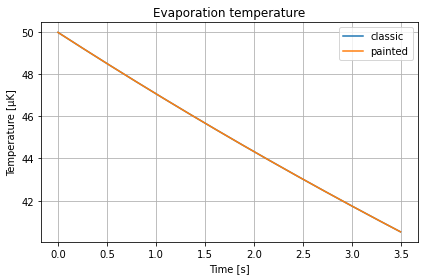

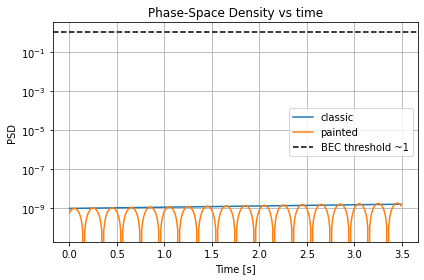

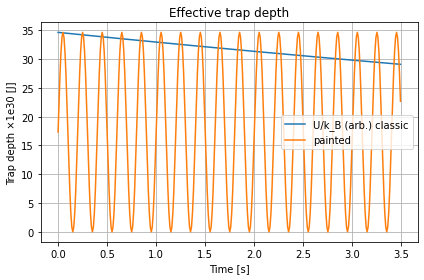

In [4]:

# Run two schedules: classic vs painted
tA, NA, TA, PSDA, UA = run_schedule(t_total=3.5, dt=0.01, use_paint=False)
tB, NB, TB, PSDB, UB = run_schedule(t_total=3.5, dt=0.01, use_paint=True)

# ---------- Plots ----------
plt.figure(); plt.plot(tA, TA*1e6, label='classic'); plt.plot(tB, TB*1e6, label='painted')
plt.xlabel('Time [s]'); plt.ylabel('Temperature [µK]'); plt.title('Evaporation temperature'); plt.grid(); plt.legend()
plt.tight_layout(); 
#plt.savefig('primus_temp.png', dpi=160)

plt.figure(); plt.semilogy(tA, PSDA, label='classic'); plt.semilogy(tB, PSDB, label='painted')
plt.axhline(1.0, color='k', ls='--', label='BEC threshold ~1')
plt.xlabel('Time [s]'); plt.ylabel('PSD'); plt.title('Phase-Space Density vs time'); plt.grid(); plt.legend()
plt.tight_layout(); 
#plt.savefig('primus_psd.png', dpi=160)

plt.figure(); plt.plot(tA, UA*1e30, label='U/k_B (arb.) classic'); plt.plot(tB, UB*1e30, label='painted')
plt.xlabel('Time [s]'); plt.ylabel('Trap depth ×1e30 [J]'); plt.title('Effective trap depth'); plt.grid(); plt.legend()
plt.tight_layout(); 
#plt.savefig('primus_trapdepth.png', dpi=160)

